In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pd.options.mode.chained_assignment = None

https://www.analyticsvidhya.com/blog/2020/10/a-definitive-guide-for-predicting-customer-lifetime-value-clv/

In [2]:
# This may take a couple minutes
data = pd.read_csv('data.csv', parse_dates=['InvoiceDate'])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


* **InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter ‘c’, it indicates a cancellation.
* **StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* **Description**: Product (item) name. Nominal.
* **Quantity**: The quantities of each product (item) per transaction. Numeric.
* **InvoiceDate**: Invoice Date and time. Numeric, the day and time when each transaction was generated.
* **UnitPrice**: Unit price. Numeric, Product price per unit in sterling.
* **CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* **Country**: Country name. Nominal, the name of the country where each customer resides.

In [4]:
print("Total number of transactions happened in the given period: "+ str(data.shape[0]))
data.head()

Total number of transactions happened in the given period: 541909


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# Feature selection
features = ['CustomerID', 'InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice']
data_clv = data[features]
data_clv['TotalSales'] = data_clv['Quantity'].multiply(data_clv['UnitPrice'])

print(data_clv.shape)
data_clv.head()

(541909, 6)


,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,TotalSales
0,17850.0,536365,2010-12-01 08:26:00,6,2.55,15.30
1,17850.0,536365,2010-12-01 08:26:00,6,3.39,20.34
2,17850.0,536365,2010-12-01 08:26:00,8,2.75,22.00
3,17850.0,536365,2010-12-01 08:26:00,6,3.39,20.34
4,17850.0,536365,2010-12-01 08:26:00,6,3.39,20.34


Now, let's look at the discriptive statistics of the data.

In [6]:
data_clv.describe()

,CustomerID,Quantity,UnitPrice,TotalSales
count,406829.000000,541909.000000,541909.000000,541909.000000
mean,15287.690570,9.552250,4.611114,17.987795
std,1713.600303,218.081158,96.759853,378.810824
min,12346.000000,-80995.000000,-11062.060000,-168469.600000
25%,13953.000000,1.000000,1.250000,3.400000
50%,15152.000000,3.000000,2.080000,9.750000
75%,16791.000000,10.000000,4.130000,17.400000
max,18287.000000,80995.000000,38970.000000,168469.600000


In [7]:
data_clv = data_clv[data_clv['TotalSales'] > 0]
data_clv.describe()

,CustomerID,Quantity,UnitPrice,TotalSales
count,397884.000000,530104.000000,530104.000000,530104.000000
mean,15294.423453,10.542037,3.907625,20.121871
std,1713.141560,155.524124,35.915681,270.356743
min,12346.000000,1.000000,0.001000,0.001000
25%,13969.000000,1.000000,1.250000,3.750000
50%,15159.000000,3.000000,2.080000,9.900000
75%,16795.000000,10.000000,4.130000,17.700000
max,18287.000000,80995.000000,13541.330000,168469.600000


In [8]:
pd.DataFrame(zip(data_clv.isnull().sum(), data_clv.isnull().sum()/len(data_clv)), 
             columns=['Count', 'Proportion'], index=data_clv.columns)

,Count,Proportion
CustomerID,132220,0.249423
InvoiceNo,0,0.000000
InvoiceDate,0,0.000000
Quantity,0,0.000000
UnitPrice,0,0.000000
TotalSales,0,0.000000


So, clearly we have around 24% missing values in the CustomerID variable.

The main objective of our project is to calculate the lifetime value of each customer. Here each customer is identified by the unique CustomerID.Then How could we able to do that, if we don't have CustomerID in the first place?

So, let's drop the null values in the CustomerID variable.

In [9]:
# Dropping the null values in the CustomerID variable
data_clv = data_clv[pd.notnull(data_clv['CustomerID'])]
pd.DataFrame(zip(data_clv.isnull().sum(), data_clv.isnull().sum()/len(data_clv)), 
             columns=['Count', 'Proportion'], index=data_clv.columns)

,Count,Proportion
CustomerID,0,0.0
InvoiceNo,0,0.0
InvoiceDate,0,0.0
Quantity,0,0.0
UnitPrice,0,0.0
TotalSales,0,0.0


In [10]:
# Printing the details of the dataset
maxdate = data_clv['InvoiceDate'].dt.date.max()
mindate = data_clv['InvoiceDate'].dt.date.min()
unique_cust = data_clv['CustomerID'].nunique()
tot_quantity = data_clv['Quantity'].sum()
tot_sales = data_clv['TotalSales'].sum()

print(f"The Time range of transactions is: {mindate} to {maxdate}")
print(f"Total number of unique customers: {unique_cust}")
print(f"Total Quantity Sold: {tot_quantity}")
print(f"Total Sales for the period: {tot_sales}")

The Time range of transactions is: 2010-12-01 to 2011-12-09
Total number of unique customers: 4338
Total Quantity Sold: 5167812
Total Sales for the period: 8911407.904


## 1. Aggregate Model
The most simplest and the oldest method of computing CLV is this Aggregate/Average method. This assumes a constant average spend and churn rate for all the customers.

This method does not differentiate between customers and produces a single value for CLV at an overall Level. This leads to unrealistic estimates if some of the customers transacted in high value and high volume, which ultimately skews the average CLV value.

The General Formula for calculating CLV is:

**CLV = ((Average Sales X Purchase Frequency) / Churn) X Profit Margin**

Where,
Average Sales = TotalSales/Total no. of orders

Purchase Frequency = Total no. of orders/Total unique customers

Retention rate = Total no. of orders greater than 1/ Total unique customers

Churn = 1 - Retention rate

Profit Margin = Based on business context

In this example case, I am assuming the Profit margin for each transaction to be roughly 5%.

In [11]:
# Transforming the data to customer level for the analysis
customer = data_clv.groupby('CustomerID').agg({'InvoiceDate':lambda x: (x.max() - x.min()).days, 
                                                   'InvoiceNo': lambda x: len(x),
                                                  'TotalSales': lambda x: sum(x)})

customer.columns = ['Age', 'Frequency', 'TotalSales']
customer.head()

,Age,Frequency,TotalSales
CustomerID,,,
12346.0,0,1,77183.60
12347.0,365,182,4310.00
12348.0,282,31,1797.24
12349.0,0,73,1757.55
12350.0,0,17,334.40


In [12]:
# Calculating the necessary variables for CLV calculation
Average_sales = round(np.mean(customer['TotalSales']),2)
print(f"Average sales: ${Average_sales}")

Purchase_freq = round(np.mean(customer['Frequency']), 2)
print(f"Purchase Frequency: {Purchase_freq}")

Retention_rate = customer[customer['Frequency']>1].shape[0]/customer.shape[0]
churn = round(1 - Retention_rate, 2)
print(f"Churn: {churn}%")

Average sales: $2054.27
Purchase Frequency: 91.72
Churn: 0.02%


In [13]:
# Calculating the CLV
Profit_margin = 0.05 

CLV = round(((Average_sales * Purchase_freq/churn)) * Profit_margin, 2)
print(f"The Customer Lifetime Value (CLV) for each customer is: ${CLV}")

The Customer Lifetime Value (CLV) for each customer is: $471044.11


From our basic model, we got a CLV value of $471K for each customer. Do you think this number makes sense? Well it doesn't for me!

The reason is becasue of the very high sales value from very few customers, which actually skewed the overall number. Also, not all the customers are same right!

Take a look at it for yourself:

In [14]:
customer['TotalSales'].describe()

count      4338.000000
mean       2054.266460
std        8989.230441
min           3.750000
25%         307.415000
50%         674.485000
75%        1661.740000
max      280206.020000
Name: TotalSales, dtype: float64

From the descriptive statistics it is clear that, almost 75% of customers in our data have sales value less than 2000. Whereas, the maximum sales value is around 280k. If you now look at the CLV value, do you think all the customers who transact with the business can really generate over 470K in their lifetime? Definitely not! It varies for each customers or atleast for each customer segments.

This is another limitation of this model.

## 2. Cohort Model
Instead of simply assuming all the customers to be one group, we can try to split them into multiple groups based and calculate the CLV for each group. This model overcomes the major drawback of the simple Aggregate model which assumes the entire customers as a single group. This is called Cohort model.

The main assumption of this model is that, customers within a cohort spend similarly.

The most common way to group customers into cohorts is by the start date of a customer, typically by month. The best choice will depend on the customer acquisition rate, seasonality of business, and whether additional customer information can be used.

In this case, I am grouping them into different cohorts by their start month. So, I will get 12 cohorts of customers (Jan-Dec).

In [15]:
# Transforming the data to customer level for the analysis
customer = data_clv.groupby('CustomerID').agg({'InvoiceDate':lambda x: x.min().month, 
                                                   'InvoiceNo': lambda x: len(x),
                                                  'TotalSales': lambda x: np.sum(x)})

customer.columns = ['Start_Month', 'Frequency', 'TotalSales']
customer.head()

,Start_Month,Frequency,TotalSales
CustomerID,,,
12346.0,1,1,77183.60
12347.0,12,182,4310.00
12348.0,12,31,1797.24
12349.0,11,73,1757.55
12350.0,2,17,334.40


In [16]:
# Calculating CLV for each cohort
months = ['Jan', 'Feb', 'March', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
Monthly_CLV = []

for i in range(1, 13):
    customer_m = customer[customer['Start_Month']==i]
    
    Average_sales = round(np.mean(customer_m['TotalSales']),2)
    
    Purchase_freq = round(np.mean(customer_m['Frequency']), 2)
    
    Retention_rate = customer_m[customer_m['Frequency']>1].shape[0]/customer_m.shape[0]
    churn = round(1 - Retention_rate, 2)
    
    CLV = round(((Average_sales * Purchase_freq/churn)) * Profit_margin, 2)
    
    Monthly_CLV.append(CLV)

In [17]:
monthly_clv = pd.DataFrame(zip(months, Monthly_CLV), columns=['Months', 'CLV'])
monthly_clv

,Months,CLV
0,Jan,1546537.09
1,Feb,313073.92
2,March,539933.18
3,Apr,349213.35
4,May,147597.49
5,Jun,323795.77
6,Jul,71760.42
7,Aug,148834.42
8,Sep,185155.70
9,Oct,144042.95


Now if you look at the result, we have 12 different CLV value for 12 months from Jan-Dec. And it is pretty clear that, customers who are acquired in different months have different CLV values attached to them. This is because, they could be acquired using different campaigns etc., so thier behaviour might be different from others.

Also, if you look at the values for the month of Janaury and December, the CLV values are quite high. This could be a false value, because the data we are using is from a online retails who sell gifts to wholesalers/companies and the festivals like Christmas, Newyear falls on those months. That's why we are seeing a high CLV value for those customers who are started on the month of January and December.

### 3. BG/NBD Model (with Gamma-Gamma extension)
BG/NBD stands for Beta Geometric/Negative Binomial Distribution.

This is one of the most commonly used probabilistic model for predicting the CLV. This is an alternative to the Pareto/NBD model, which is also one of the most used method in CLV calculations. For the sake of this case, we are going to focus only on BG/NBD model, but the steps are similar if you want to try it for Pareto/NBD.

To be precise, both the BG/NBD and Pareto/NBD model actually tries to predict the future transactions of each customer. It is then combined with Gamma-Gamma model, which then adds the monetary aspect of the customer transaction and we finally get the customer lifetime value (CLV).

The BG/NBD model has few assumptions:

1. When a user is active, number of transactions in a time t is described by Poisson distribution with rate lambda.
2. Heterogeneity in transaction across users (difference in purchasing behavior across users) has Gamma distribution with shape parameter r and scale parameter a.
3. Users may become inactive after any transaction with probability p and their dropout point is distributed between purchases with Geometric distribution.
4. Heterogeneity in dropout probability has Beta distribution with the two shape parameters alpha and beta.
5. Transaction rate and dropout probability vary independently across users.

These are some of the assumptions this model considers for predicting the future transactions of a customer.

The model technically fits the distribution to the historic data and learn the distribution parameter and then use them to predict future transactions of a customer.

We don't need to worry about carrying out this complex probabilistic model by ourself. There is a Python package called Lifetimes which makes our life much simpler. This package is primarily built to aid customer lifetime value calculations, predicting customer churn, etc. It has all the major models and utility functions which are needed for CLV calculations.

In this case, we are going to use just that. Let's jump into the coding.

In [18]:
# Importing the lifetimes package
import lifetimes

First we need to create a summary table from the transactions data. The summary table is nothing but RFM table. (RFM - Recency, Frequency and Monetary value)

For this we can use summary_data_from_transactions_data function in lifetimes package. What it does is, it aggregates the transaction level data into customer level and calculates the frequency, recency, T and monetary_value for each customer.

* **frequency** - the number of repeat purchases (more than 1 purchases)
* **recency** - the time between the first and the last transaction
* **T** - the time between the first purchase and the end of the transaction period
* **monetary_value** - it is the mean of a given customers sales value

NOTE: If you closely look at the definition of recency and T, you can find that, the actual value of recency should be (T - recency), because the definition of recency is how recent a customer made a transaction with the business.

In [19]:
# Creating the summary data using summary_data_from_transaction_data function
summary = lifetimes.utils.summary_data_from_transaction_data(data_clv, 'CustomerID', 'InvoiceDate', 'TotalSales' )
summary = summary.reset_index()
summary.head()

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,599.701667
2,12348.0,3.0,283.0,358.0,301.480000
3,12349.0,0.0,0.0,18.0,0.000000
4,12350.0,0.0,0.0,310.0,0.000000


Here the value of 0 in frequency and recency means that, these are one time buyers. Let's check how many such one time buyers are there in our data.

count    4338.000000
mean        2.864223
std         5.949000
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
---------------------------------------
Percentage of customers purchase the item only once: 35.68 %


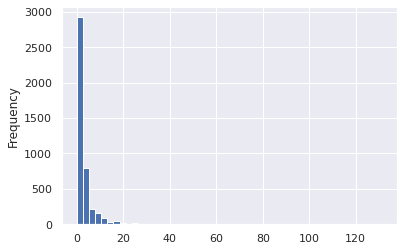

In [20]:
# Create a distribution of frequency to understand the customer frequence level
summary['frequency'].plot(kind='hist', bins=50)
print(summary['frequency'].describe())
print("---------------------------------------")
one_time_buyers = round(sum(summary['frequency'] == 0)/float(len(summary))*(100),2)
print("Percentage of customers purchase the item only once:", one_time_buyers ,"%")

Now, let's fit the BG/NBD model to our summary data.

BG/NBD model is available as BetaGeoFitter class in lifetimes package.

In [21]:

# Fitting the BG/NBD model
bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 4338 subjects, a: 0.00, alpha: 68.91, b: 6.75, r: 0.83>

In [22]:
# Model summary
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826542,0.026785,0.774044,0.879040
alpha,68.905121,2.611786,63.786020,74.024221
a,0.003437,0.010339,-0.016828,0.023702
b,6.745116,22.414725,-37.187745,50.677978


The above table shows the estimated distribution parameter values from the historical data. The model now uses this to predict the future transactions and the customer churn rate.

So, let's say you want to know whether a customer is now alive or not (or predict customer churn) based on the historical data. The lifetimes package provides a way to accomplish that task. You can use:

1. **model.conditional_probability_alive()**: This method computes the probability that a customer with history (frequency, recency, T) is currently alive.

2. **plot_probabilty_alive_matrix(model)**: This function from lifetimes.plotting will help to visually analyze the relationship between recency & frequency and the customer being alive.

In [23]:
# Compute the customer alive probability
summary['probability_alive'] = bgf.conditional_probability_alive(summary['frequency'], summary['recency'], summary['T'])
summary.head(10)

,CustomerID,frequency,recency,T,monetary_value,probability_alive
0,12346.0,0.0,0.0,325.0,0.000000,1.000000
1,12347.0,6.0,365.0,367.0,599.701667,0.999698
2,12348.0,3.0,283.0,358.0,301.480000,0.999177
3,12349.0,0.0,0.0,18.0,0.000000,1.000000
4,12350.0,0.0,0.0,310.0,0.000000,1.000000
5,12352.0,6.0,260.0,296.0,368.256667,0.999406
6,12353.0,0.0,0.0,204.0,0.000000,1.000000
7,12354.0,0.0,0.0,232.0,0.000000,1.000000
8,12355.0,0.0,0.0,214.0,0.000000,1.000000
9,12356.0,2.0,303.0,325.0,269.905000,0.999478


<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

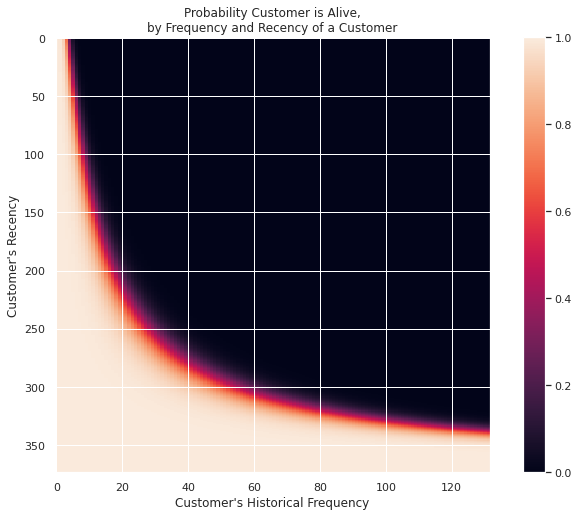

In [24]:
# Visual representation of relationship between recency and frequency
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

Let me explain the above two results.

The probabilty of being alive is calculated based on the recency and frequency of a customer. So,

If a customer has bought multiple times (frequency) and the time between first & last transaction is high (recency), then his/her probability being alive is high.
Similarly, if a customer has less frequency (bought once or twice) and the time between first & last transaction is low (recency), then his/her probability being alive is high.
Next thing we can do with this trained model is to predict the likely future transactions for each customer. You can use:

1. model.conditional_expected_number_of_purchases_up_to_time(): Calculate the expected number of repeat purchases up to time t for a randomly chosen individual from the population (or the whole population), given they have purchase history (frequency, recency, T).

In [25]:
#Predict future transaction for the next 30 days based on historical dataa
t = 30
summary['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T']),2)
summary.sort_values(by='pred_num_txn', ascending=False).head(10).reset_index()

,index,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
0,1879,14911.0,131.0,372.0,373.0,1093.661679,0.999966,8.95
1,326,12748.0,112.0,373.0,373.0,301.024821,0.999971,7.66
2,4010,17841.0,111.0,372.0,373.0,364.452162,0.999962,7.59
3,2176,15311.0,89.0,373.0,373.0,677.729438,0.999964,6.10
4,1661,14606.0,88.0,372.0,373.0,135.890114,0.999955,6.03
5,481,12971.0,70.0,369.0,372.0,159.211286,0.999926,4.82
6,562,13089.0,65.0,367.0,369.0,893.714308,0.999934,4.51
7,1602,14527.0,53.0,367.0,369.0,155.016415,0.999925,3.69
8,1069,13798.0,52.0,371.0,372.0,706.650962,0.999933,3.59
9,2990,16422.0,47.0,352.0,369.0,702.472340,0.999567,3.27


We now have the prediction for number of purchases a customer will make in the next 10 days.

To check whether the predicted number makes sense, we can try something like this:

Let's take CustomerID - 14911,

In 372 days, he purchased 131 times. So, in one day he purchases 131/372 = 0.352 times. Hence, for 10 days = 3.52 times.

Here, our predicted result is 2.98, which is close to the manual probability prediction we did above. The reason for the difference is caused by the various assumptions about the customers, such as the dropout rate, customers lifetime being modeled as exponential distribution, etc.

Now that we predicted the expected future transactions, we now need to predict the future monetary value of each transactions.

Like I have previously mentioned above, the BG/NBD model can only be able to predict the future transactions and churn rate of a customer. In order to add the monetary aspect of the problem, we have to model the monetary value using the **Gamma-Gamma Model**.

Some of the key assumptions of Gamma-Gamma model are:

1. The monetary value of a customer's given transaction varies randomly around their average transaction value.
2. Average transaction value varies across customers but do not vary over time for any given customer.
3. The distribution of average transaction values across customers is independent of the transaction process.

As a first step before fitting the model to the data, we have to check whether the assumptions made by the model holds good for the data. Only if it satisfies, we have proceed further.

Out of the three, the final assumption can be validated. What it means is that, there is no relationship between frequency and monetary value of transactions. This can be easily validated using Pearson correlation.

NOTE: We are considering only customers who made repeat purchases with the business i.e., frequency > 0. Because, if frequency is 0, it means that they are one time customer and are considered already dead.

In [26]:
# Checking the relationship between frequency and monetary_value
return_customers_summary = summary[summary['frequency']>0]
print(return_customers_summary.shape)
return_customers_summary.head()

(2790, 7)


,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
1,12347.0,6.0,365.0,367.0,599.701667,0.999698,0.47
2,12348.0,3.0,283.0,358.0,301.480000,0.999177,0.27
5,12352.0,6.0,260.0,296.0,368.256667,0.999406,0.56
9,12356.0,2.0,303.0,325.0,269.905000,0.999478,0.22
11,12358.0,1.0,149.0,150.0,683.200000,0.999486,0.25


In [27]:
# Checking the relationship between frequency and monetary_value
return_customers_summary[['frequency', 'monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.015906
monetary_value,0.015906,1.000000


The correlation seems very weak. Hence, we can conclude that, the assumption is satisfied and we can fit the model to our data.

In [28]:
# Modeling the monetary value using Gamma-Gamma Model
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(return_customers_summary['frequency'],
       return_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 11.13, q: 0.84, v: 11.29>

In [29]:
# Summary of the fitted parameters
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,11.125568,0.269274,10.597792,11.653344
q,0.838782,0.019731,0.800110,0.877455
v,11.292978,0.281539,10.741162,11.844795


Next, we can predict the expected average profit for each each transaction and Customer Lifetime Value using the model.

1. model.conditional_expected_average_profit(): This method computes the conditional expectation of the average profit per transaction for a group of one or more customers.

2. model.customer_lifetime_value(): This method computes the average lifetime value of a group of one or more customers. This method takes in BG/NBD model and the prediction horizon as a parameter to calculate the CLV.

In [30]:
# Calculating the conditional expected average profit for each customer per transaction
summary = summary[summary['monetary_value'] >0]
summary['exp_avg_sales'] = ggf.conditional_expected_average_profit(summary['frequency'],
                                       summary['monetary_value'])
summary.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales
1,12347.0,6.0,365.0,367.0,599.701667,0.999698,0.47,603.040247
2,12348.0,3.0,283.0,358.0,301.480000,0.999177,0.27,306.725889
5,12352.0,6.0,260.0,296.0,368.256667,0.999406,0.56,371.034926
9,12356.0,2.0,303.0,325.0,269.905000,0.999478,0.22,277.562534
11,12358.0,1.0,149.0,150.0,683.200000,0.999486,0.25,704.704679


In [31]:
# Checking the expected average value and the actual average value in the data to make sure the values are good
print(f"Expected Average Sales: {summary['exp_avg_sales'].mean()}")
print(f"Actual Average Sales: {summary['monetary_value'].mean()}")

Expected Average Sales: 486.90902215126897
Actual Average Sales: 477.3803385139518


The values seems to be fine. Now, let's calculate the customer lifetime value directly using the method from the lifetimes package.

Three main important thing to note here is:

1. time: This parameter in customer_lifetime_value() method takes in terms of months i.e., t=1 means one month and so on.

2. freq: This parameter is where you will specify the time unit your data is in. If your data is in daily level then "D", monthly "M" and so on.

3. discount_rate: This parameter is based on the concept of DCF (discounted cash flow), where you will discount the future monetary value by a discount rate to get the present value of that cash flow. In the documentation, it is given that for monthly it is 0.01 (annually ~12.7%).

In [32]:
# Predicting Customer Lifetime Value for the next 30 days
summary['predicted_clv'] =      ggf.customer_lifetime_value(bgf,
                                                               summary['frequency'],
                                                               summary['recency'],
                                                               summary['T'],
                                                               summary['monetary_value'],
                                                               time=1,     # lifetime in months
                                                               freq='D',   # frequency in which the data is present(T)      
                                                               discount_rate=0.01) # discount rate
summary.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv
1,12347.0,6.0,365.0,367.0,599.701667,0.999698,0.47,603.040247,280.409518
2,12348.0,3.0,283.0,358.0,301.480000,0.999177,0.27,306.725889,81.591026
5,12352.0,6.0,260.0,296.0,368.256667,0.999406,0.56,371.034926,206.034640
9,12356.0,2.0,303.0,325.0,269.905000,0.999478,0.22,277.562534,59.125290
11,12358.0,1.0,149.0,150.0,683.200000,0.999486,0.25,704.704679,174.550478


You can also calculate the CLV manually from the predicted number of future transactions (pred_num_txn) and expected average sales per transaction (exp_avg_sales).



In [33]:
summary['manual_predicted_clv'] = summary['pred_num_txn'] * summary['exp_avg_sales']
summary.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv
1,12347.0,6.0,365.0,367.0,599.701667,0.999698,0.47,603.040247,280.409518,283.428916
2,12348.0,3.0,283.0,358.0,301.480000,0.999177,0.27,306.725889,81.591026,82.815990
5,12352.0,6.0,260.0,296.0,368.256667,0.999406,0.56,371.034926,206.034640,207.779558
9,12356.0,2.0,303.0,325.0,269.905000,0.999478,0.22,277.562534,59.125290,61.063757
11,12358.0,1.0,149.0,150.0,683.200000,0.999486,0.25,704.704679,174.550478,176.176170


In [34]:
# CLV in terms of profit (profit margin is 5%)
profit_margin = 0.05
summary['CLV'] = summary['predicted_clv'] * profit_margin
summary.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv,CLV
1,12347.0,6.0,365.0,367.0,599.701667,0.999698,0.47,603.040247,280.409518,283.428916,14.020476
2,12348.0,3.0,283.0,358.0,301.480000,0.999177,0.27,306.725889,81.591026,82.815990,4.079551
5,12352.0,6.0,260.0,296.0,368.256667,0.999406,0.56,371.034926,206.034640,207.779558,10.301732
9,12356.0,2.0,303.0,325.0,269.905000,0.999478,0.22,277.562534,59.125290,61.063757,2.956265
11,12358.0,1.0,149.0,150.0,683.200000,0.999486,0.25,704.704679,174.550478,176.176170,8.727524


In [35]:
# Distribution of CLV for the business in the next 30 days
summary['CLV'].describe()

count    2790.000000
mean       12.312040
std        49.327361
min         0.136205
25%         2.826065
50%         5.668581
75%        10.967735
max      1692.149403
Name: CLV, dtype: float64

Finally, we predicted the CLV for each customers for the next 30 days.

The marketing team can now use this information to target customers and increase their sales.

Also, it is hard to target each individual customers. If we have access to customer demographics data, we can first create customer segmentation and then predict the CLV value for each segments. This segment level information can then be used for personalized targeting. If there is no access/availability of customer demographics data, then an easy way would be use RFM segmentation and then predict CLV for those RFM segments.

Thanks for reading this far. I hope you enjoyed and learned as much as I did while I worked on this case study.
Please share your suggestions and comments on the case study.
